In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score,
                             roc_curve, auc,ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [19]:
t=pd.read_csv('/content/drive/MyDrive/Lab_performance/Titanic - Machine Learning from Disaster.csv')

In [41]:
t

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [43]:
file_name = '/content/drive/MyDrive/Lab_performance/Titanic - Machine Learning from Disaster.csv'
df = pd.read_csv(file_name)

**Data Preprocessing**

In [44]:
# --- Data Cleaning ---

# 1. Handle Missing Values:
# 'Age': Impute with median
df['Age'].fillna(df['Age'].median(), inplace=True)
# 'Fare': Impute with median
df['Fare'].fillna(df['Fare'].median(), inplace=True)
# 'Cabin': Too many missing values. Drop the column.
df.drop('Cabin', axis=1, inplace=True)

# 2. Remove Duplicate Rows:
df.drop_duplicates(inplace=True)

# 3. Drop Unnecessary Features:
df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

print("Data Cleaning Complete. Ready for EDA.")
print(df.head())

Data Cleaning Complete. Ready for EDA.
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S


**Encoding & Feature scaling**

In [45]:
# Define features (X) and multi-class target (y)
X = df.drop('Embarked', axis=1)
y = df['Embarked'] # Last column is the target

# --- Target Encoding (Label Encoding for Multi-Class Target) ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# Store the classes for reporting later: ['C', 'Q', 'S'] -> [0, 1, 2]
target_classes = le.classes_
print(f"Embarked classes encoded: {le.classes_}")

# --- Feature Encoding (One-Hot Encoding for X) ---
X_encoded = pd.get_dummies(X, columns=['Sex', 'Pclass'], drop_first=True)

# --- Feature Scaling (StandardScaler) ---
numerical_cols = ['Age', 'Fare', 'SibSp', 'Parch']
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

# --- Train-Test Split (80% Train / 20% Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Embarked classes encoded: ['C' 'Q' 'S']

X_train shape: (334, 7)
X_test shape: (84, 7)


**Histogram**

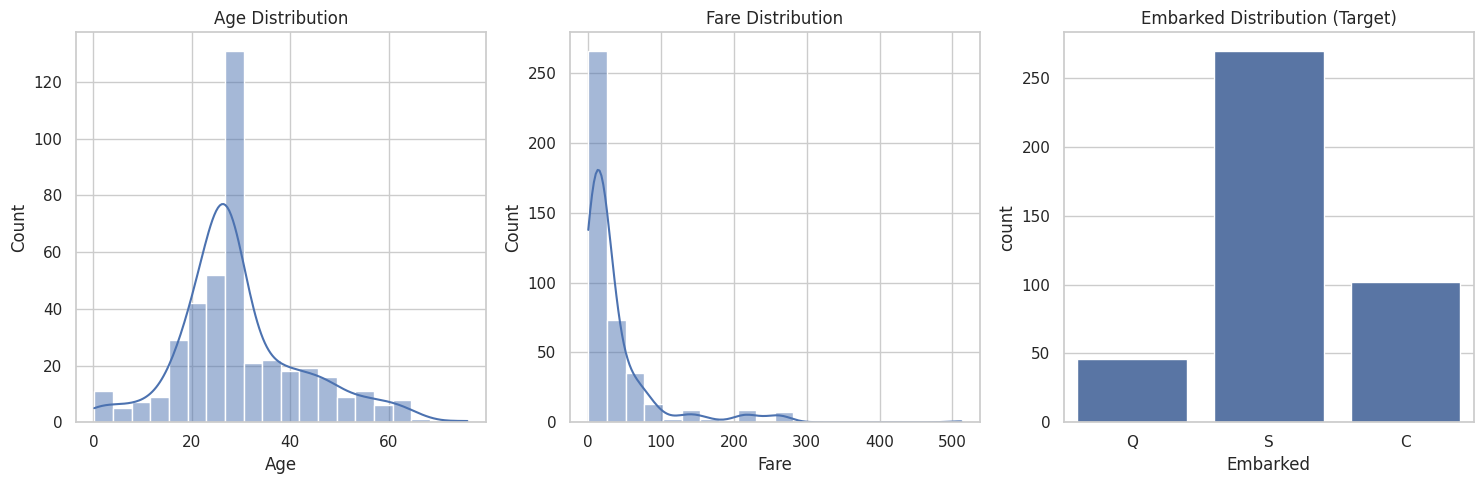

In [46]:
# Set up the visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# 1. Histograms (Feature Distribution)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.subplot(1, 3, 2)
sns.histplot(df['Fare'], kde=True, bins=20)
plt.title('Fare Distribution')
plt.subplot(1, 3, 3)
# Distribution of the new target variable
sns.countplot(x='Embarked', data=df)
plt.title('Embarked Distribution (Target)')
plt.tight_layout()
plt.savefig('Histograms_EDA.png')
plt.show()

**Scatter Plot**

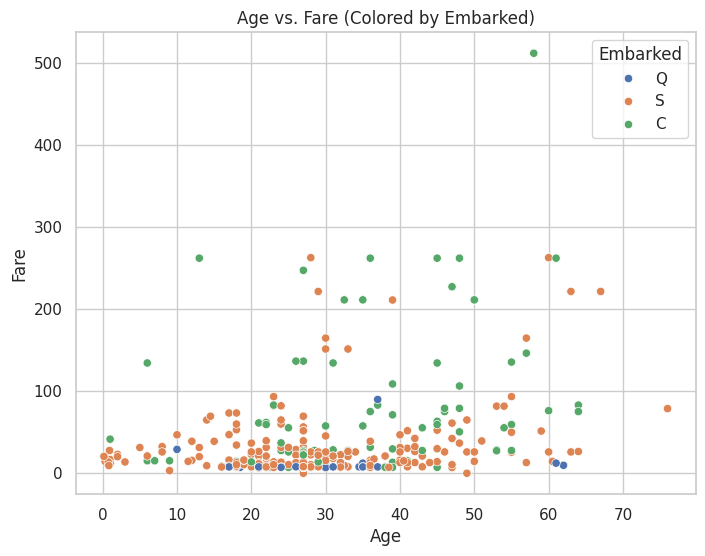

In [47]:
# 2. Scatter Plots (Example: Age vs. Fare colored by Embarked)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Fare', hue='Embarked', data=df)
plt.title('Age vs. Fare (Colored by Embarked)')
plt.savefig('ScatterPlot_Embarked.png')
plt.show()



**Correlation Heatmap**

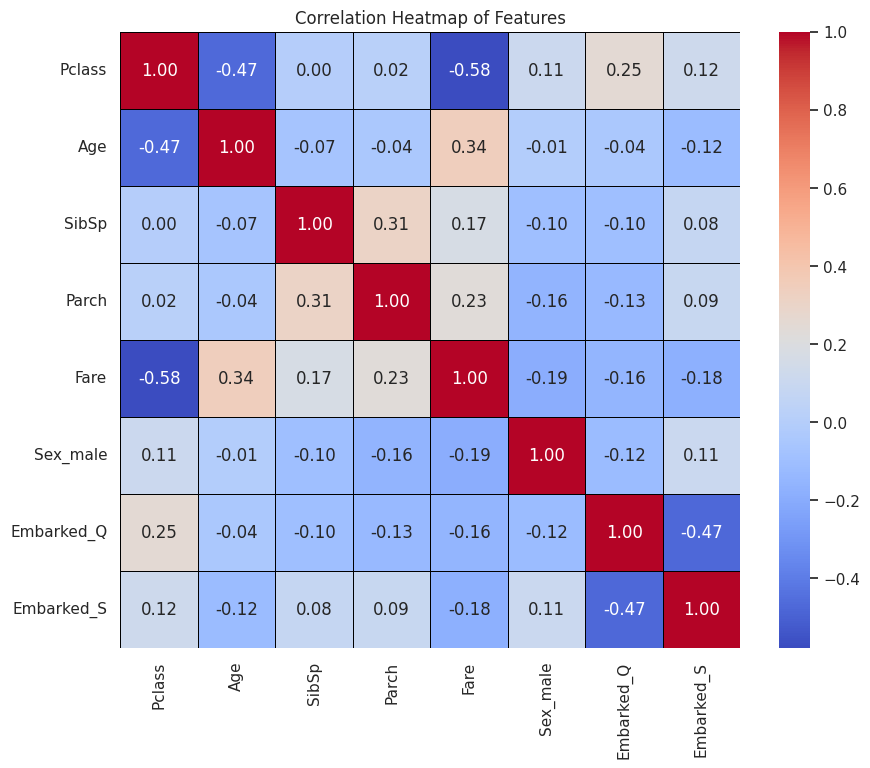

In [48]:
# 3. Correlation Heatmap
# Need to encode categorical features temporarily for correlation calculation
df_corr = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Correlation Heatmap of Features')
plt.savefig('Correlation_Heatmap.png')
plt.show()

**Logistic Regression**

 Model 1: Logistic Regression


<Figure size 800x800 with 0 Axes>

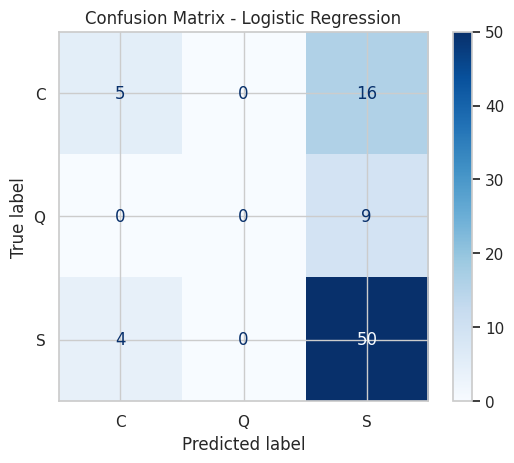


Classification Report:
              precision    recall  f1-score   support

           C       0.56      0.24      0.33        21
           Q       0.00      0.00      0.00         9
           S       0.67      0.93      0.78        54

    accuracy                           0.65        84
   macro avg       0.41      0.39      0.37        84
weighted avg       0.57      0.65      0.58        84



In [62]:
# Model 1 - Logistic Regression (with CM Plot)

print(" Model 1: Logistic Regression")
log_reg = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
y_prob_log_reg = log_reg.predict_proba(X_test)

# Confusion Matrix PLOT
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=target_classes)
plt.figure(figsize=(8, 8))
disp_log_reg.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.savefig('CM_LogisticRegression.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=target_classes))



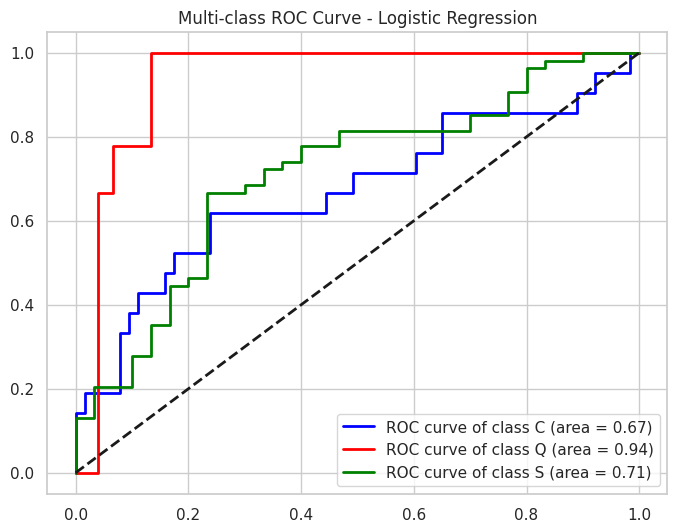

In [51]:
# ROC Curve Plot (Multi-Class One-vs-Rest)
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(target_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob_log_reg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {target_classes[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multi-class ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('ROC_Multiclass_LogisticRegression.png')
plt.show()

**K-Nearest Neighbors (KNN)**

Model 2: K-Nearest Neighbors (KNN)


<Figure size 800x800 with 0 Axes>

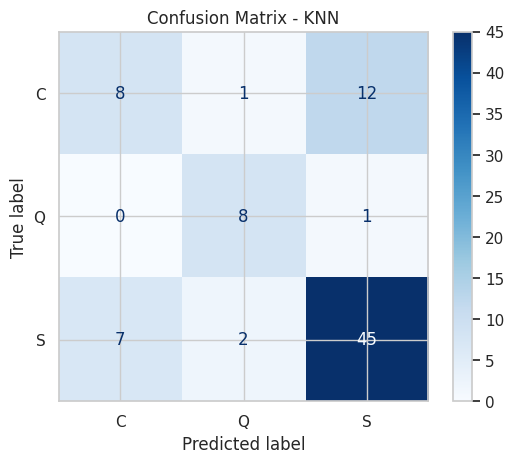


Classification Report:
              precision    recall  f1-score   support

           C       0.53      0.38      0.44        21
           Q       0.73      0.89      0.80         9
           S       0.78      0.83      0.80        54

    accuracy                           0.73        84
   macro avg       0.68      0.70      0.68        84
weighted avg       0.71      0.73      0.71        84



In [63]:
#Model 2 K-Nearest Neighbors (KNN) (with CM Plot)

print("Model 2: K-Nearest Neighbors (KNN)")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Confusion Matrix PLOT
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=target_classes)
plt.figure(figsize=(8, 8))
disp_knn.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - KNN')
plt.savefig('CM_KNN.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=target_classes))


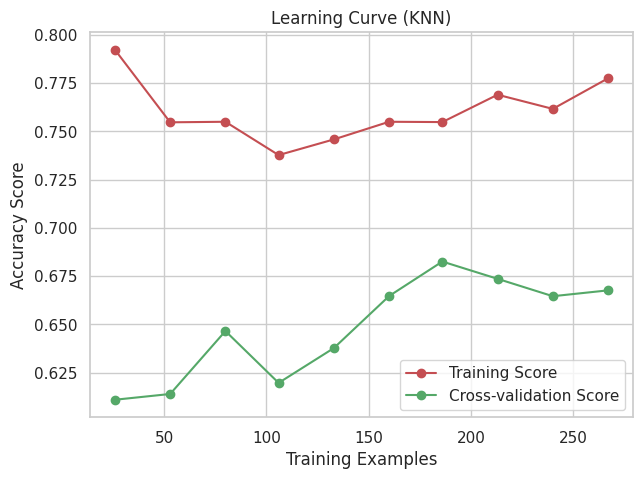

In [53]:
# Learning Curve Plot
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve (KNN)")
plt.legend(loc="best")
plt.savefig('Learning_Curve_KNN.png')
plt.show()

**Decision Tree**

Model 3: Decision Tree Classifier


<Figure size 800x800 with 0 Axes>

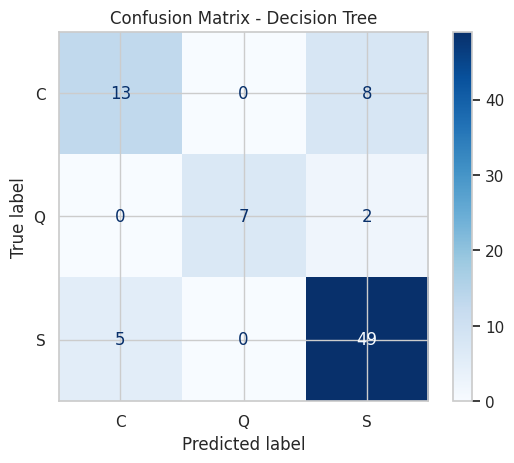


Classification Report:
              precision    recall  f1-score   support

           C       0.72      0.62      0.67        21
           Q       1.00      0.78      0.88         9
           S       0.83      0.91      0.87        54

    accuracy                           0.82        84
   macro avg       0.85      0.77      0.80        84
weighted avg       0.82      0.82      0.82        84



In [64]:
#  Model 3 - Decision Tree Classifier (with CM Plot)

print("Model 3: Decision Tree Classifier")
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

# Confusion Matrix PLOT
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=target_classes)
plt.figure(figsize=(8, 8))
disp_dt.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Decision Tree')
plt.savefig('CM_DecisionTree.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=target_classes))
# CODE CELL 5: Model 3 - Decision Tree Classifier (with CM Plot)


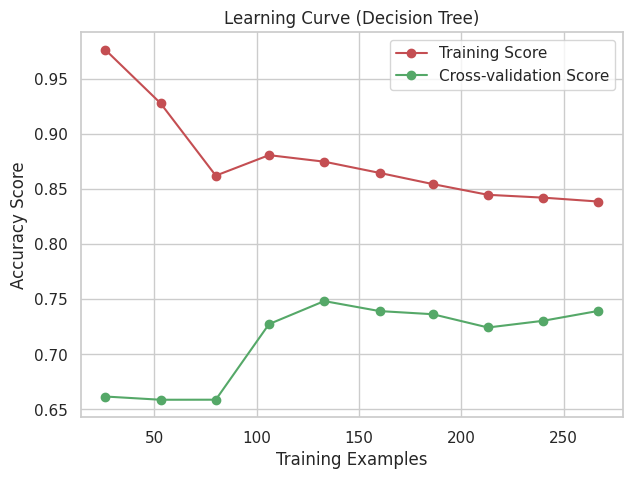

In [55]:
# Learning Curve Plot
train_sizes, train_scores, test_scores = learning_curve(
    dt_clf, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve (Decision Tree)")
plt.legend(loc="best")
plt.savefig('Learning_Curve_DecisionTree.png')
plt.show()

**Random Forest Classifier**

 Model 4: Random Forest Classifier 


<Figure size 800x800 with 0 Axes>

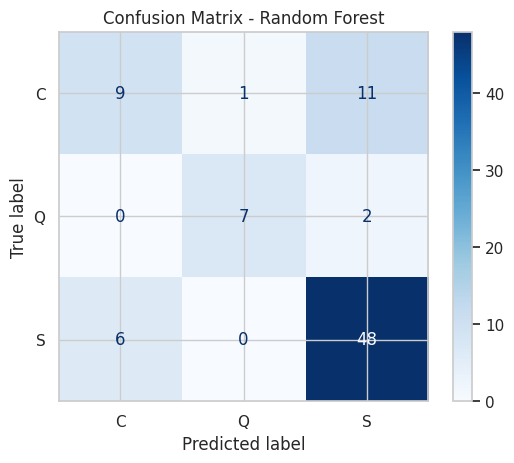


Classification Report:
              precision    recall  f1-score   support

           C       0.60      0.43      0.50        21
           Q       0.88      0.78      0.82         9
           S       0.79      0.89      0.83        54

    accuracy                           0.76        84
   macro avg       0.75      0.70      0.72        84
weighted avg       0.75      0.76      0.75        84



In [66]:
# Model 4 - Random Forest Classifier (with CM Plot)

print(" Model 4: Random Forest Classifier ")
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Confusion Matrix PLOT
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=target_classes)
plt.figure(figsize=(8, 8))
disp_rf.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.savefig('CM_RandomForest.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_classes))

**Support Vector Machine**

Model 5: Support Vector Machine (SVM)


<Figure size 800x800 with 0 Axes>

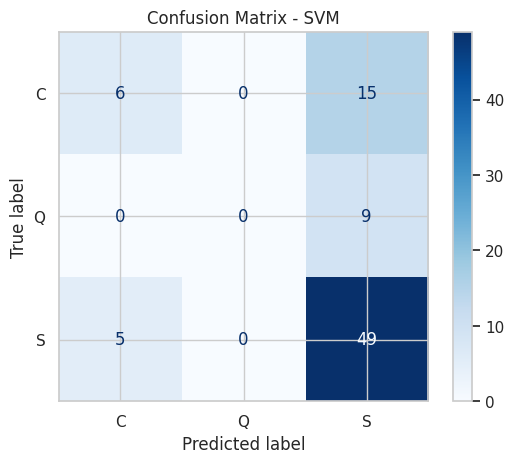


Classification Report:
              precision    recall  f1-score   support

           C       0.55      0.29      0.38        21
           Q       0.00      0.00      0.00         9
           S       0.67      0.91      0.77        54

    accuracy                           0.65        84
   macro avg       0.41      0.40      0.38        84
weighted avg       0.57      0.65      0.59        84



In [67]:
# Model 5 - Support Vector Machine (SVM) (with CM Plot)

print("Model 5: Support Vector Machine (SVM)")
svm_clf = SVC(random_state=42, decision_function_shape='ovr')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# Confusion Matrix PLOT
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=target_classes)
plt.figure(figsize=(8, 8))
disp_svm.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - SVM')
plt.savefig('CM_SVM.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=target_classes))

In [69]:
# Summary of Model Results

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

models = {
    "Logistic Regression": log_reg,
    "K-Nearest Neighbors": knn,
    "Decision Tree": dt_clf,
    "Random Forest": rf_clf,
    "Support Vector Machine": svm_clf
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': f'{accuracy:.4f}',
        'F1-Score': f'{f1:.4f}',
        'Precision': f'{precision:.4f}',
        'Recall': f'{recall:.4f}'
    })

results_df = pd.DataFrame(results)
print(" Model Performance Summary (Multi-Class Classification)")
print(results_df)

# Save the final summary table
results_df.to_csv('Model_Performance_Summary.csv', index=False)

 Model Performance Summary (Multi-Class Classification)
                    Model Accuracy F1-Score Precision  Recall
0     Logistic Regression   0.6548   0.5817    0.5675  0.6548
1     K-Nearest Neighbors   0.7262   0.7134    0.7100  0.7262
2           Decision Tree   0.8214   0.8179    0.8216  0.8214
3           Random Forest   0.7619   0.7499    0.7496  0.7619
4  Support Vector Machine   0.6548   0.5898    0.5679  0.6548
